
# Advance Lane Finding Project

## Chessboard Calibration

In [1]:
import cv2
import glob
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

imgpts = []

chessColumns = 9
chessRows = 6

chessDim = (chessColumns, chessRows)

# List comprehension instead of glob to make it easier to pick out
# a particular image to undistort.
calibimgpaths = ['camera_cal/calibration{}.jpg'.format(i) for i in range(1,20+1)]
print(calibimgpaths)

calibimgs = list(map(cv2.imread, calibimgpaths))

for img in calibimgs:
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, chessDim)
    #print('ret: {}, corners: {}'.format(ret, corners))
    if ret:
        imgpts.append(corners)
    
    imgcorners = img.copy()
    #cv2.drawChessboardCorners(imgcorners, chessDim, corners, ret)
    #plt.imshow(img)

# 3D points for chessboard lying in xz-plane
objp = np.zeros((chessColumns*chessRows,3), np.float32)
objp[:,:2] = np.mgrid[0:chessColumns,0:chessRows].T.reshape(-1,2) # keep third dimension 

objpts = [objp] * len(imgpts)

imageDim = calibimgs[0].shape[1::-1]

ret, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, imageDim, None, None)

['camera_cal/calibration1.jpg', 'camera_cal/calibration2.jpg', 'camera_cal/calibration3.jpg', 'camera_cal/calibration4.jpg', 'camera_cal/calibration5.jpg', 'camera_cal/calibration6.jpg', 'camera_cal/calibration7.jpg', 'camera_cal/calibration8.jpg', 'camera_cal/calibration9.jpg', 'camera_cal/calibration10.jpg', 'camera_cal/calibration11.jpg', 'camera_cal/calibration12.jpg', 'camera_cal/calibration13.jpg', 'camera_cal/calibration14.jpg', 'camera_cal/calibration15.jpg', 'camera_cal/calibration16.jpg', 'camera_cal/calibration17.jpg', 'camera_cal/calibration18.jpg', 'camera_cal/calibration19.jpg', 'camera_cal/calibration20.jpg']


## Undistortion

map x and y shapes: (720, 1280) (720, 1280)


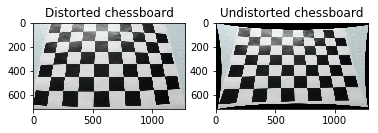

In [2]:
# Was a bit tricky to work with cv2.undistortPoints() since it doesn't output image coordinates
# when I called it like this: cv2.undistort(distorted, cameraMatrix, distCoeffs)
# Also doing this calculation once should be faster than letting cv2.undistort do it every time.
newCameraMatrix,roi = cv2.getOptimalNewCameraMatrix(cameraMatrix,distCoeffs,imageDim,1.,imageDim)
mapx,mapy = cv2.initUndistortRectifyMap(cameraMatrix,distCoeffs,None,newCameraMatrix,imageDim,cv2.CV_32FC1)
def undistort_road_img(img):
    return cv2.remap(img,mapx,mapy,cv2.INTER_LINEAR)

print('map x and y shapes: {} {}'.format(mapx.shape, mapy.shape))
def undistort_road_img_points(pts):
    #res = [(mapx[pt[1],pt[0]], mapy[pt[1],pt[0]]) for pt in np.rint(pts).astype(int)]
    #return np.array(res, np.float32)
    pts = pts[:,np.newaxis,:]
    res = cv2.undistortPoints(pts, cameraMatrix, distCoeffs, P=newCameraMatrix)
    res = np.squeeze(res)
    return res

# Show one img restored
distorted = calibimgs[3-1]
undistorted = undistort_road_img(distorted) #cv2.undistort(distorted, cameraMatrix, distCoeffs)

plt.subplot(121)
plt.title('Distorted chessboard')
plt.imshow(distorted)

plt.subplot(122)
plt.title('Undistorted chessboard')
plt.imshow(undistorted)

## Thresholding

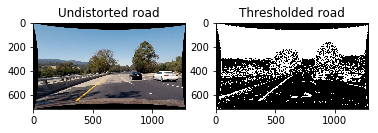

In [3]:
# Thresholding of the warped image.
# Code from udacity exercise "Color and Gradient"
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    #print('s_channel: {}'.format(s_channel[-100:-80,-100:-80]))
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 255
    
    kernel = np.ones((7,7),np.uint8)
    sxmorph = cv2.dilate(sxbinary,kernel,iterations = 1)
    
    # Threshold color channel
    s_binary = np.zeros_like(scaled_sobel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 255
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    result = np.zeros_like(scaled_sobel)
    result[(sxbinary > 0) | (s_binary > 0)] = 255
    return result
    #return s_binary
    #return sxbinary
    #return s_channel

distorted = cv2.imread('test_images/test4.jpg')
undistorted = undistort_road_img(distorted)
cv2.imwrite()

thresholded = pipeline(undistorted, s_thresh=(100,255), sx_thresh=(12, 100))
cv2.imwrite('output_images/thresholded_image.jpg', thresholded)

plt.subplot(121)
plt.title('Undistorted road')
plt.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.title('Thresholded road')
plt.imshow(thresholded, cmap='gray')

## Unwarped view of lane area

[[  260.   720.]
 [  260.     0.]
 [ 1020.     0.]
 [ 1020.   720.]]


True

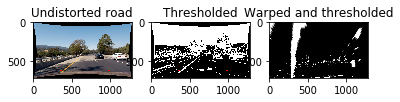

In [4]:
# Distorted coordinates for straight_lines2.jpg
#srcpts = np.array([(308,656), (615,435), (666,435), (1012,656)], np.float32)
# Positions on lane from test_images/straight_lines2.jpg. The positions are distorted.
srcpts = np.array([(308,656), (588,455), (697,455), (1012,656)], np.float32)
srcptsUndistorted = undistort_road_img_points(srcpts)

# From Section 35. Measuring Curvature in course "We could do this in detail by measuring out the
# physical lane in the field of view of the camera, but for this project, you can assume that if
# you're projecting a section of lane similar to the images above, the lane is about 30 meters
# long and 3.7 meters wide."
unwrappedDim = (1280,720)
# The spacing in pixels to the side of the lane
sidemargin = 260
#dstpts = np.multiply(np.array([(0,1), (0,0), (1,0), (1,1)], np.float32), np.float32(unwrappedDim))
dstpts = np.array([
    (sidemargin,unwrappedDim[1]),
    (sidemargin,0),
    (unwrappedDim[0]-sidemargin,0),
    (unwrappedDim[0]-sidemargin,unwrappedDim[1])],
    np.float32)
print(dstpts)
M = cv2.getPerspectiveTransform(srcptsUndistorted, dstpts)
Minv = np.linalg.inv(M)

def unwarp_lane(img):
    warped = cv2.warpPerspective(img, M, tuple(unwrappedDim), flags=cv2.INTER_LINEAR)
    return warped

def from_unwarped_to_warped(warped):
    #return cv2.warpPerspective(warped, M, tuple(imageDim), cv2.INTER_LINEAR | cv2.WARP_INVERSE_MAP)
    return cv2.warpPerspective(warped, Minv, tuple(imageDim), cv2.INTER_LINEAR)

kernel = np.ones((3,3),np.uint8)
# The lane contours have pixels set, but the middle doesn't a closing homography
# fixes that and makes the sliding window search better.
def close_binary_lane_img(thresholded):
    return cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)

thresholded = close_binary_lane_img(thresholded)

warpedthresholded = unwarp_lane(thresholded)

undistortedWithSrcPoints = undistorted.copy()
thresholdedWithSrcPoints = np.array(cv2.merge((thresholded,thresholded,thresholded)),np.uint8)
for img in [undistortedWithSrcPoints, thresholdedWithSrcPoints]:
    for pt in srcptsUndistorted:
        cv2.circle(img, (pt[0],pt[1]), 6, (0,0,255), 2)

plt.subplot(131)
plt.title('Undistorted road')
plt.imshow(cv2.cvtColor(undistortedWithSrcPoints, cv2.COLOR_BGR2RGB))
cv2.imwrite('output_images/undistorted_with_warppoints.jpg', undistortedWithSrcPoints)

plt.subplot(132)
plt.title('Thresholded')
plt.imshow(cv2.cvtColor(thresholdedWithSrcPoints, cv2.COLOR_BGR2RGB))
    
plt.subplot(133)
plt.title('Warped and thresholded')
plt.imshow(warpedthresholded, cmap='gray')
cv2.imwrite('output_images/unwarpedlines.jpg', warpedthresholded)

## Finding of lane lines

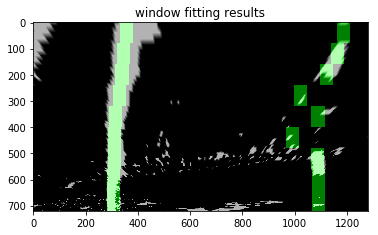

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Code heavily adopted from section "Sliding Window Search"

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
        
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def draw_window_centroids(window_centroids, warped):
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 0.7, template, 0.5, 0.0) # overlay the orignal road image with window results
        #output = warpedthresholded
        #print('warpage.shape: {}'.format(warpage.shape))
        #smallwarpage = warpage[700:719,180:210,:]
        #print('smallwarpage: {}'.format(smallwarpage))
        #print('histogram: {}'.format(np.histogram(warpage.flatten().reshape(-1,3))))
        #print('row: {}'.format(warpage[719,:,:]))
        #print('row histogram: {}'.format(cv2.calcHist(warpage[719,:,:], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])))
        # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    return output

window_centroids = find_window_centroids(warpedthresholded, window_width, window_height, margin)

output = draw_window_centroids(window_centroids, warpedthresholded)

cv2.imwrite('output_images/lane_location.jpg', output)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


## Fit polygon to the points

In [6]:
from scipy.optimize import least_squares

def robust_fitting(xvalues, yvalues, guess=None):
    # Trying to make fitting more robust to outliers. In this case outliers
    # are white pixels, which are not from a lane line. Inspired from:
    # http://scipy-cookbook.readthedocs.io/items/robust_regression.html
    
    if guess == None:
        # My inital guess is that it is strait vertical lines starting at the median of each lane
        medianx = np.mean(xvalues)
        guess = [0, 0, medianx]

    # Computes residual, which is difference from pixel x and extimated x
    # given an y given coefficents.
    def fun(coeff, yvalues, xvalues):
        return np.poly1d(coeff)(yvalues) - xvalues
    lsq = least_squares(fun, guess, loss='soft_l1', f_scale=0.2, args=(yvalues, xvalues))

    # .x contains the coefficents
    return lsq.x

# Heavily adopted from section "Finding the lines"
# part "Implement Sliding Windows and Fit a Polynomial".
def fit_poly_around_centroids(window_centroids, img):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Set the width of the windows +/- margin
    margin = 100

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    for level in range(0,len(window_centroids)):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (level+1)*window_height
        win_y_high = img.shape[0] - level*window_height
        leftx_current, rightx_current = window_centroids[level]
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    return robust_fitting(leftx,lefty),robust_fitting(rightx,righty)

left_fit,right_fit = fit_poly_around_centroids(window_centroids, warpedthresholded)

## Visualization of the fitted lines

True

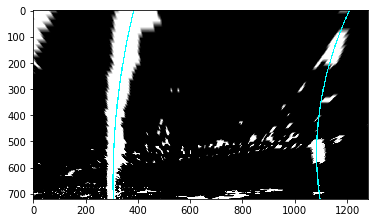

In [7]:
# Heavily adopted from section "Finding the lines"
# part "Visualization".
def draw_fitted_polylines(img):
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    polygon_img = cv2.merge((img,img,img))
    
    def draw_helper(xvalues, yvalues):
        pts = cv2.merge((xvalues,yvalues))
        pts = np.array(pts, int)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(polygon_img,[pts],False,(0,255,255), 4)

    draw_helper(left_fitx,ploty)
    draw_helper(right_fitx,ploty)
    return polygon_img

polygon_img = draw_fitted_polylines(warpedthresholded)

plt.imshow(polygon_img)

cv2.imwrite('output_images/birdseye_fitted_polygon.jpg', polygon_img)

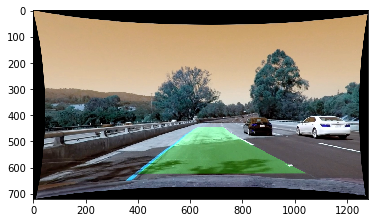

In [8]:
# Modified version of code from section "Tips and Tricks for the Project"
def draw_lane_on_image(warpedthresholded, undistorted, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    color_warp = np.zeros((warpedthresholded.shape[0], warpedthresholded.shape[1], 3), dtype=np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = from_unwarped_to_warped(color_warp)

    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    return result

imagewithcoloredlane = draw_lane_on_image(warpedthresholded, undistorted, left_fit, right_fit)
plt.imshow(imagewithcoloredlane)

## Curvature and position in lane

Curvature left:  886.656049903 m Curvature right:  389.289062724 m
"Average" curvature:  541.035032322 m
Distance to center:  0.298256853812 m


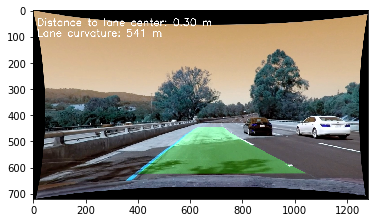

In [9]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Define y-value where we want radius of curvature to be evaulated
# I'll choose an y-value at roughly bottom of image
y_eval = 630

def find_curvature_radius(poly):
    A = poly[0]
    B = poly[1]
    
    # This rescaling of coefficients to meters explained in report.
    y_eval_meters = ym_per_pix * y_eval
    A = xm_per_pix/ym_per_pix**2 * A
    B = xm_per_pix/ym_per_pix * B

    # Based on section "Measuring Curvature" heading "Radius of Curvature" in course.
    # Calculate the new radii of curvature
    curverad = ((1 + (2*A*y_eval_meters + B)**2)**1.5) / np.absolute(2*A)
    
    # Now our radius of curvature is in meters
    return curverad

def average_curve_radius(left_curverad,right_curverad):
    # To me radius feels a bit more volatile than the inverse radius, so I average the inverse radius
    return 2./(1./left_curverad + 1./right_curverad)

def find_distance_to_center(left_fit, right_fit):
    leftpos = np.poly1d(left_fit)(y_eval)
    rightpos = np.poly1d(right_fit)(y_eval)
    lanemiddlepixel = (leftpos + rightpos)/2.
    dist_to_center_pixel = np.absolute(unwrappedDim[0]/2 - lanemiddlepixel)
    dist_to_center = xm_per_pix * dist_to_center_pixel
    return dist_to_center

left_curverad,right_curverad=find_curvature_radius(left_fit), find_curvature_radius(right_fit)
print('Curvature left: ', left_curverad, 'm', 'Curvature right: ', right_curverad, 'm')
average_curverad = average_curve_radius(left_curverad,right_curverad)
print('"Average" curvature: ', average_curverad, 'm')
dist_to_center = find_distance_to_center(left_fit, right_fit)
print('Distance to center: ', dist_to_center, 'm')

def draw_info(img, average_curverad, dist_to_center):
    cv2.putText(img,'Distance to lane center: {:.2f} m'.format(dist_to_center),(15,60), cv2.FONT_HERSHEY_SIMPLEX, 1.3,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(img,'Lane curvature: {:.0f} m'.format(average_curverad),(15,100), cv2.FONT_HERSHEY_SIMPLEX, 1.3,(255,255,255),2,cv2.LINE_AA)

imgwithinfo = imagewithcoloredlane.copy()
draw_info(imgwithinfo, average_curverad, dist_to_center)
plt.imshow(imgwithinfo)

In [10]:
def fit_polynom_around_old_polynom(warpedthresholded, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "warpedthresholded")
    # It's now much easier to find line pixels!
    nonzero = warpedthresholded.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ## Fit a second order polynomial to each
    #left_fit = np.polyfit(lefty, leftx, 2)
    #right_fit = np.polyfit(righty, rightx, 2)
    #return left_fit,right_fit
    
    return robust_fitting(leftx,lefty,left_fit), robust_fitting(rightx,righty,right_fit)

## Video pipeline

In [13]:
from moviepy.editor import VideoFileClip

class RoadProcessing:
    def __init__(self):
        self.old_left_fit = None
        self.old_right_fit = None

    def process_frame(self, frame):
        undistorted = undistort_road_img(frame)

        thresholded = pipeline(undistorted, s_thresh=(160,255), sx_thresh=(20, 100))

        thresholded = close_binary_lane_img(thresholded)

        warpedthresholded = unwarp_lane(thresholded)

        if self.old_left_fit == None:
            window_centroids = find_window_centroids(warpedthresholded, window_width, window_height, margin)

            left_fit,right_fit = fit_poly_around_centroids(window_centroids, warpedthresholded)
        else:
            left_fit,right_fit = fit_polynom_around_old_polynom(warpedthresholded, self.old_left_fit, self.old_right_fit)

        left_curverad,right_curverad=find_curvature_radius(left_fit), find_curvature_radius(right_fit)

        average_curverad = average_curve_radius(left_curverad,right_curverad)
        
        dist_to_center = find_distance_to_center(left_fit, right_fit)

        image_with_marked_lane = draw_lane_on_image(warpedthresholded, undistorted, left_fit, right_fit)
        
        draw_info(image_with_marked_lane, average_curverad, dist_to_center)
        #thresholded3 = cv2.merge((thresholded,thresholded,thresholded))
        #image_with_marked_lane = draw_lane_on_image(warpedthresholded, thresholded3, left_fit, right_fit)

        self.old_left_fit,self.old_right_fit = left_fit,right_fit
        
        return image_with_marked_lane

def process_road_video(infilename, outfilename):
    road_processing = RoadProcessing()
    clip = VideoFileClip(infilename)
    clip_blurred = clip.fl_image(lambda frame: road_processing.process_frame(frame))
    clip_blurred.write_videofile(outfilename)
                
process_road_video('project_video.mp4', 'output_images/processed_project_video.mp4')

[MoviePy] >>>> Building video output_images/processed_project_video.mp4
[MoviePy] Writing audio in processed_project_videoTEMP_MPY_wvf_snd.mp3


100%|██████████| 1112/1112 [00:00<00:00, 2005.75it/s]

[MoviePy] Done.
[MoviePy] Writing video output_images/processed_project_video.mp4



100%|█████████▉| 1260/1261 [06:01<00:00,  3.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/processed_project_video.mp4 

